# SNIS-IPLA & SVGD-EM Tests

## Hierarchical Toy Model

In [1]:
import numpy as np
from tqdm import tqdm
from implementation import IPLA, SNIS_IPLA, PGD, SVGD_EM
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import datasets
import pandas as pd
from scipy import stats
plt.rcParams['figure.dpi'] = 200
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


In [2]:
file_path = "data/breast-cancer-wisconsin.data"

full_data = pd.read_csv(file_path, delimiter=",", header=None, index_col=0)
# replace non numeric values with NaN
full_data = full_data.where(full_data.applymap(
    lambda x: str(x).isdigit()
))

full_data.dropna(inplace=True)
full_data = full_data.astype(int)
features = full_data.iloc[:, :-1].to_numpy()
features = (features-features.mean(axis=0)) / features.std(axis=0)
labels = (full_data.iloc[:, -1].to_numpy()-2)/2

train_indices = np.random.choice(np.arange(len(labels)), size=int(0.8*len(labels)), replace=False)
test_indices = np.array([i for i in np.arange(len(labels)) if i not in train_indices])
train_features = features[train_indices]
train_labels = labels[train_indices]
test_features = features[test_indices]
test_labels = labels[test_indices]
y_train = [train_features, train_labels]
y_test = [test_features, test_labels]

### Auxiliary functions

We will test with:

$$
p(\theta,x, y) = \prod_{d=1}^D\exp\left(-\frac{(x_d-\theta)^2}{2} - \frac{(y_d-x_d)^2}{2}-\log(2\pi)\right)
$$

$$
= \exp\left(-D\log(2\pi)-\left[\sum_{d=1}^D\frac{(x_d-\theta)^2}{2} + \frac{(y_d-x_d)^2}{2}\right]\right)
$$

$$
\nabla_\theta p(\theta,x,y) = p(\theta, x, y)\left\{\sum_{d=1}^D x_d - D\theta\right\}
$$

In [3]:
def p(theta, X, y):
    """
    Probability density function of the toy model

    Inputs:
    theta - parameter
    X - data matrix (to be updated)
    y - data (fixed)

    Output:
    p(theta, x, y)
    """

    D = np.shape(X)[0]
    return np.exp(-np.sum((X-theta)**2/2) - np.sum((y-X)**2/2) - D*np.log(2*np.pi))

def p_grad_theta(theta, X, y):
    """
    Gradient of the probability density function of the toy model

    Inputs:
    theta - parameter
    X - data matrix (to be updated)
    y - data (fixed)

    Output:
    Grad p(theta, X, y) wrt theta
    """

    D = np.shape(X)[0]
    return -(np.sum(X) - D*theta) * p(theta, X, y)

def log_p_grad_theta(theta, X, y):
    """
    Log gradient of the probability density function of the toy model

    Inputs:
    theta - parameter
    X - data matrix (to be updated)
    y - data (fixed)

    Output:
    log [grad p(theta, X, y) wrt theta]
    """

    D = X.shape[0]
    return (np.sum(X) - D*theta)*p(theta, X, y)

def U(theta, Xi, y):
    """
    Negative log probability density function of the toy model

    Inputs:
    theta - parameter
    Xi - data vector (to be updated)
    y - data (fixed)

    Output:
    -log p(theta, Xi, y)
    """

    D = np.shape(Xi)[0]
    return D * np.log(2*np.pi) + np.sum((Xi-theta)**2/2) + np.sum((y-Xi)**2/2)

def U_grad_X(theta, X, y):
    """
    Gradient of the negative log probability density function of the toy model with respect to X

    Inputs:
    theta - parameter
    X - data matrix (to be updated)
    y - data (fixed)

    Output:
    Grad -log p(theta, X, y) wrt X
    """

    return -(-2*X + y + theta)

def U_grad_theta(theta, Xi, y):
    D = np.shape(Xi)[0]
    """
    Gradient of the negative log probability density function of the toy model with respect to theta

    Inputs:
    theta - parameter
    Xi - data vector (to be updated)
    y - data (fixed), unused

    Output:
    Grad -log p(theta, Xi, y) wrt theta
    """

    return D*(theta - np.mean(Xi))

def ave_grad_U_theta(theta, X, y):
    """
    Average gradient of the negative log probability density function of the toy model with respect to theta

    Inputs:
    theta - parameter
    X - data matrix (to be updated)
    y - data (fixed), unused
    
    Output:
    1/N sum_{i=1}^N grad -log p(theta, Xi, y) wrt theta
    """

    D, N = np.shape(X)
    return D*(theta - np.mean(X))

def exponential_kernel(x1, x2, sigma=1):
    """
    Exponential kernel

    Inputs:
    x1 - vector
    x2 - vector
    sigma - bandwidth

    Output:
    exp(-||x1-x2||^2/(2*sigma^2))
    """

    return np.exp(-np.sum((x1-x2)**2)/(2*sigma**2))

def grad_exponential_kernel_x2(x1, x2, sigma=1):
    """
    Gradient of the exponential kernel with respect to x1

    Inputs:
    x1 - vector
    x2 - vector
    sigma - bandwidth

    Output:
    grad_x1 exp(-||x1-x2||^2/(2*sigma^2))
    """

    return ((x2-x1)/(sigma**2)) * np.exp(-np.sum((x1-x2)**2/(2*sigma**2)))

# SNIS IPLA

In [6]:
D = 3
nsteps = 500
Nparticles = 5
thdata = 2
X0 = np.zeros((D, Nparticles))
th0  = np.array([0.0])
y = np.random.normal(0,1, (D,1)) + np.random.normal(thdata, 1, (D,1))
best_theta = y.mean()*np.ones(nsteps)
grads_U_IPLA = (ave_grad_U_theta, U_grad_X)
grads_U_SNIS = (U_grad_theta, U_grad_X)

In [7]:
gamma_experiments = 5*1e-2
nexperiments = 10
average_thetas_dict = {"PGD": np.zeros((nsteps+1,1)), "IPLA": np.zeros((nsteps+1,1)),"SNIS-IPLA": np.zeros((nsteps+1,1)), "SVGD-EM": np.zeros((nsteps+1,1))}
for experiment in tqdm(range(nexperiments)):
    PGD_toy = PGD(th0, X0, grads_U_IPLA, gamma=gamma_experiments, y=y)
    IPLA_toy = IPLA(th0, X0, grads_U_IPLA, gamma=gamma_experiments, y=y)
    SNIS_IPLA_toy = SNIS_IPLA(th0, X0, U, grads_U_SNIS, gamma=gamma_experiments, test=False, y=y)
    SVGD_EM_toy = SVGD_EM(th0, X0, grads_U_IPLA, exponential_kernel, grad_exponential_kernel_x2, gamma=gamma_experiments, noise=1, y=y)
    for i in tqdm(range(nsteps)):
        PGD_toy.iterate()
        IPLA_toy.iterate()
        SNIS_IPLA_toy.iterate()
        SVGD_EM_toy.iterate()

    average_thetas_dict["PGD"] = average_thetas_dict["PGD"] + (1/nexperiments) * np.array(PGD_toy.thetas)
    average_thetas_dict["IPLA"] = average_thetas_dict["IPLA"] + (1/nexperiments) * np.array(IPLA_toy.thetas)
    average_thetas_dict["SNIS-IPLA"] = average_thetas_dict["SNIS-IPLA"] + (1/nexperiments) * np.array(SNIS_IPLA_toy.thetas)
    average_thetas_dict["SVGD-EM"] = average_thetas_dict["SVGD-EM"] + (1/nexperiments) * np.array(SVGD_EM_toy.thetas)

100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


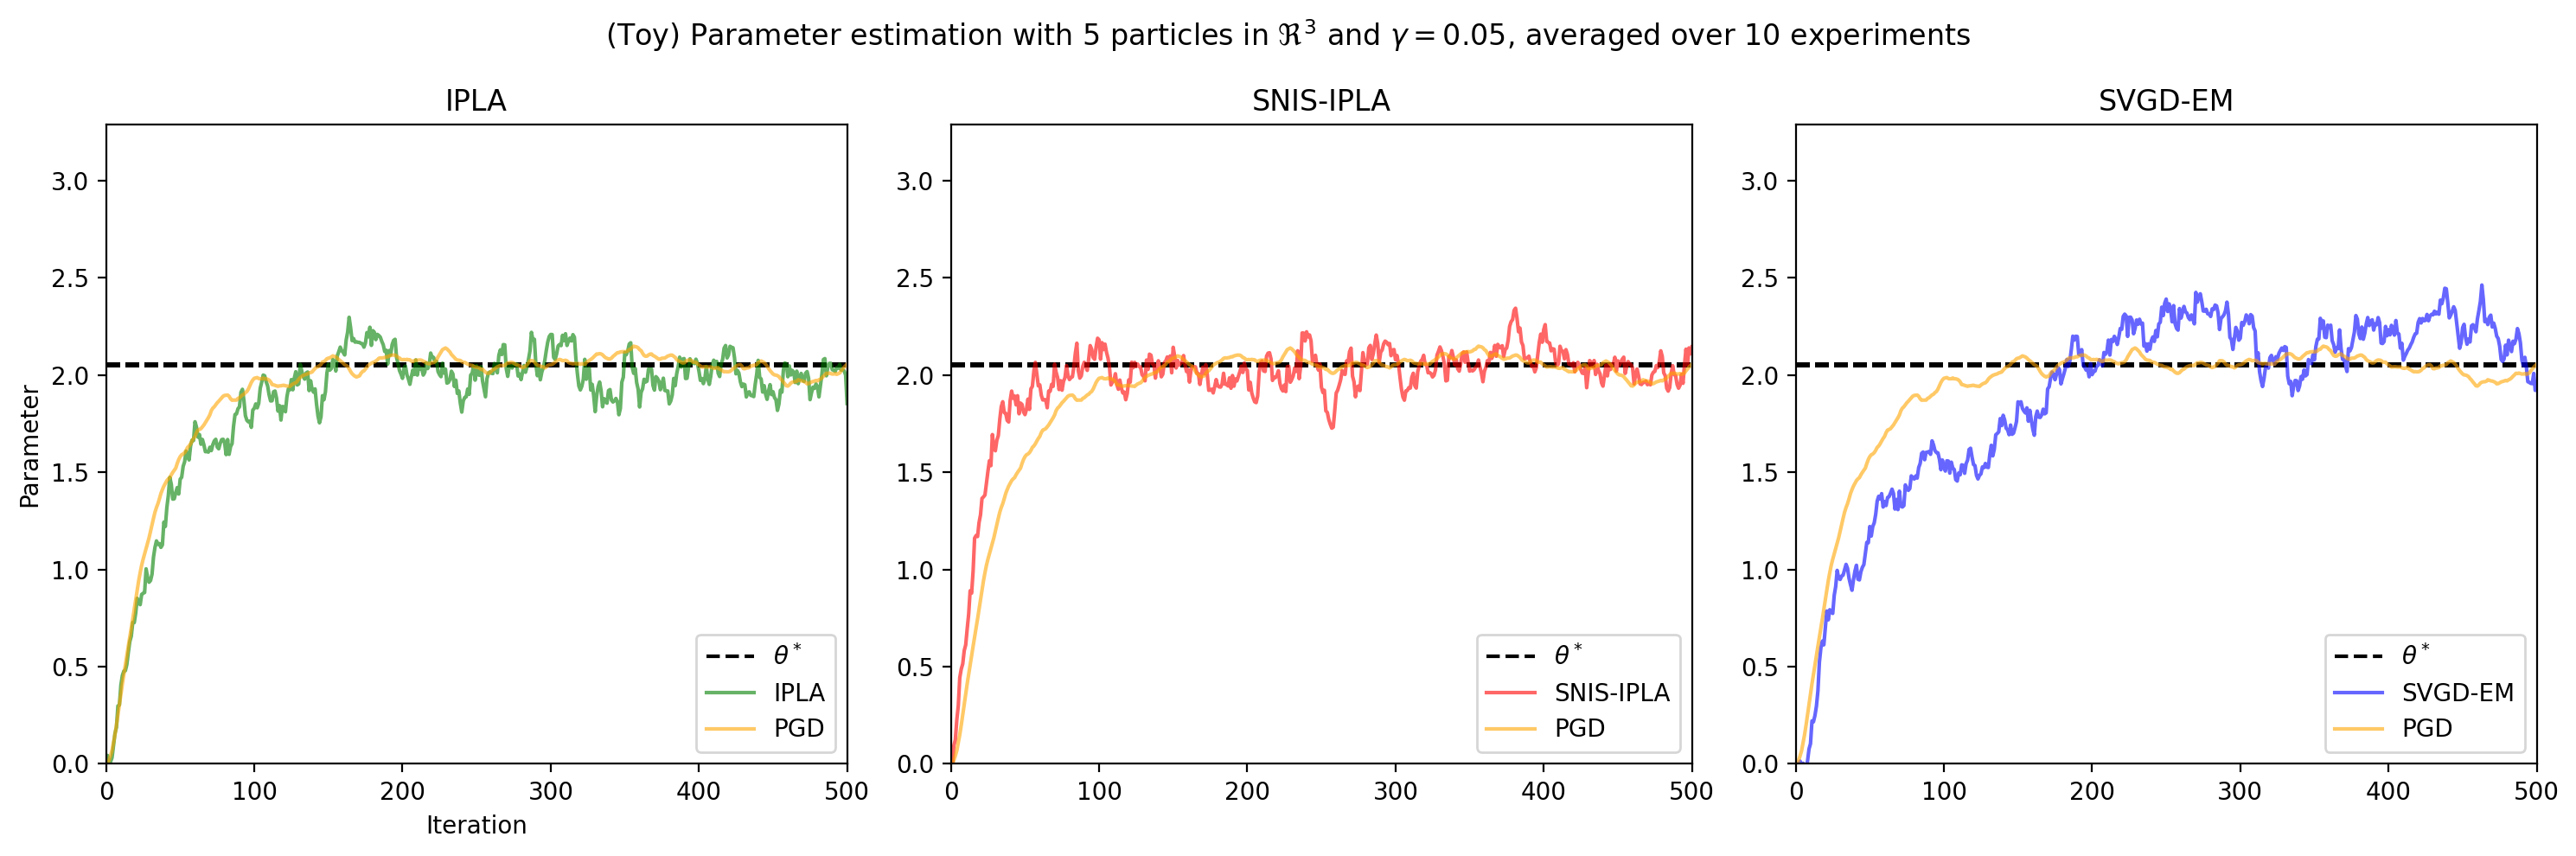

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax2.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax3.hlines(best_theta, 0, nsteps+1, linestyles="dashed", color = "black", label="$\\theta^*$")
ax1.plot(average_thetas_dict["IPLA"], color = "green", label="IPLA", alpha=0.6)
ax2.plot(average_thetas_dict["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
ax3.plot(average_thetas_dict["SVGD-EM"], color = "blue", label="SVGD-EM", alpha=0.6)
ax1.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax2.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax3.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Parameter')
ax1.set_xlim([0, nsteps])
ax1.set_ylim([0, 1.6*y.mean()])
ax1.set_title(f'IPLA')
ax1.legend(loc="lower right")
ax2.set_title(f'SNIS-IPLA')
ax2.legend(loc="lower right")
ax2.set_xlim([0, nsteps])
ax2.set_ylim([0, 1.6*y.mean()])
ax3.set_title(f'SVGD-EM')
ax3.legend(loc="lower right")
ax3.set_xlim([0, nsteps])
ax3.set_ylim([0, 1.6*y.mean()])

fig.suptitle(f"(Toy) Parameter estimation with {Nparticles} particles in $\Re^{{{D}}}$ and $\gamma = {gamma_experiments}$, averaged over {nexperiments} experiments")
fig.tight_layout()
plt.show()

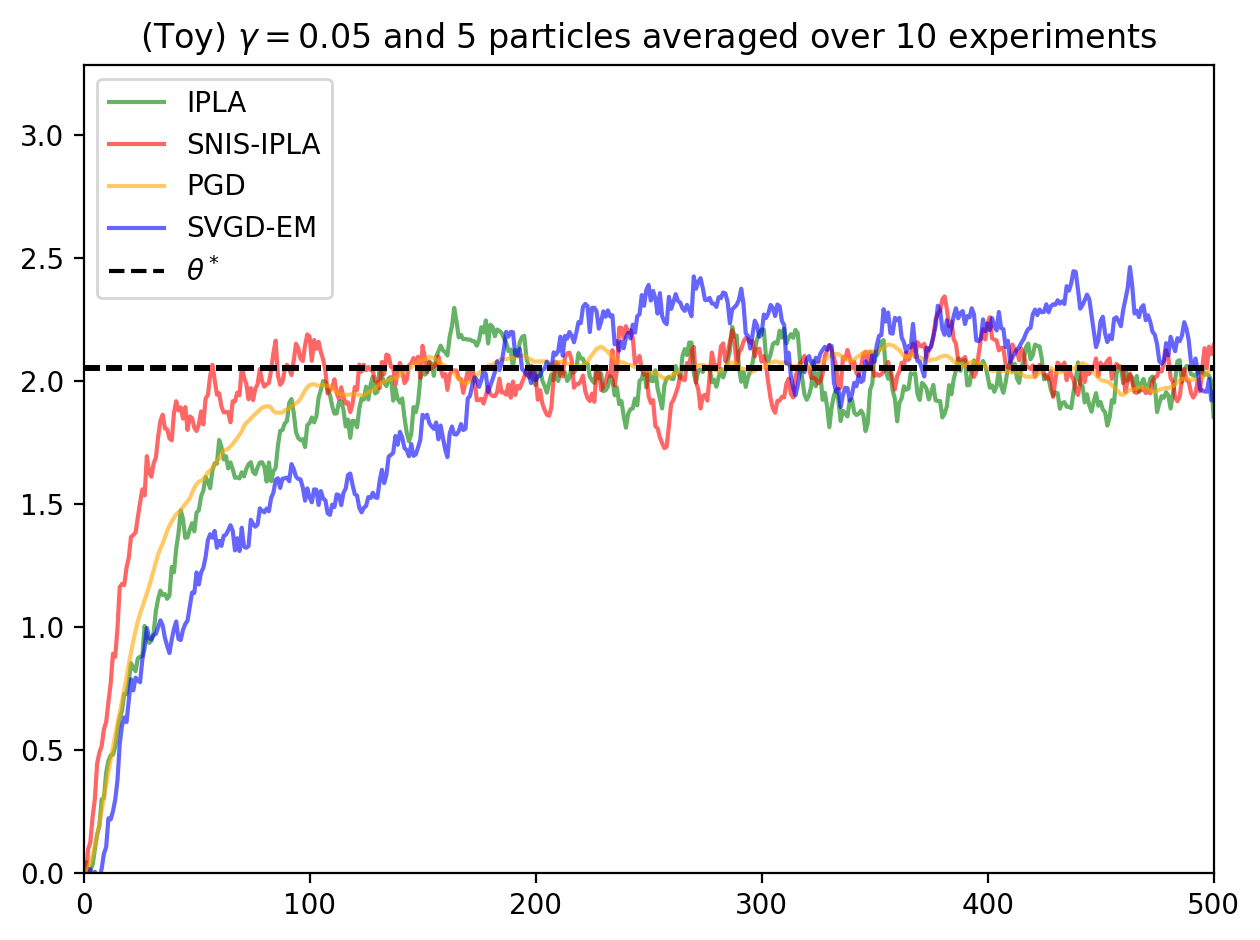

In [21]:
plt.plot(average_thetas_dict["IPLA"], color = "green", label="IPLA", alpha=0.6)
plt.plot(average_thetas_dict["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
plt.plot(average_thetas_dict["PGD"], color = "orange", label="PGD", alpha=0.6)
plt.plot(average_thetas_dict["SVGD-EM"], color = "blue", label="SVGD-EM", alpha=0.6)
plt.hlines(best_theta, 0, nsteps+1, linestyles="dashed", label = "$\\theta^*$", color="black")
plt.title(f"(Toy) $\gamma = {gamma_experiments}$ and {Nparticles} particles averaged over {nexperiments} experiments")
plt.xlim([0, nsteps])
plt.ylim([0, 1.6*y.mean()])
plt.legend()
plt.tight_layout()
plt.show()

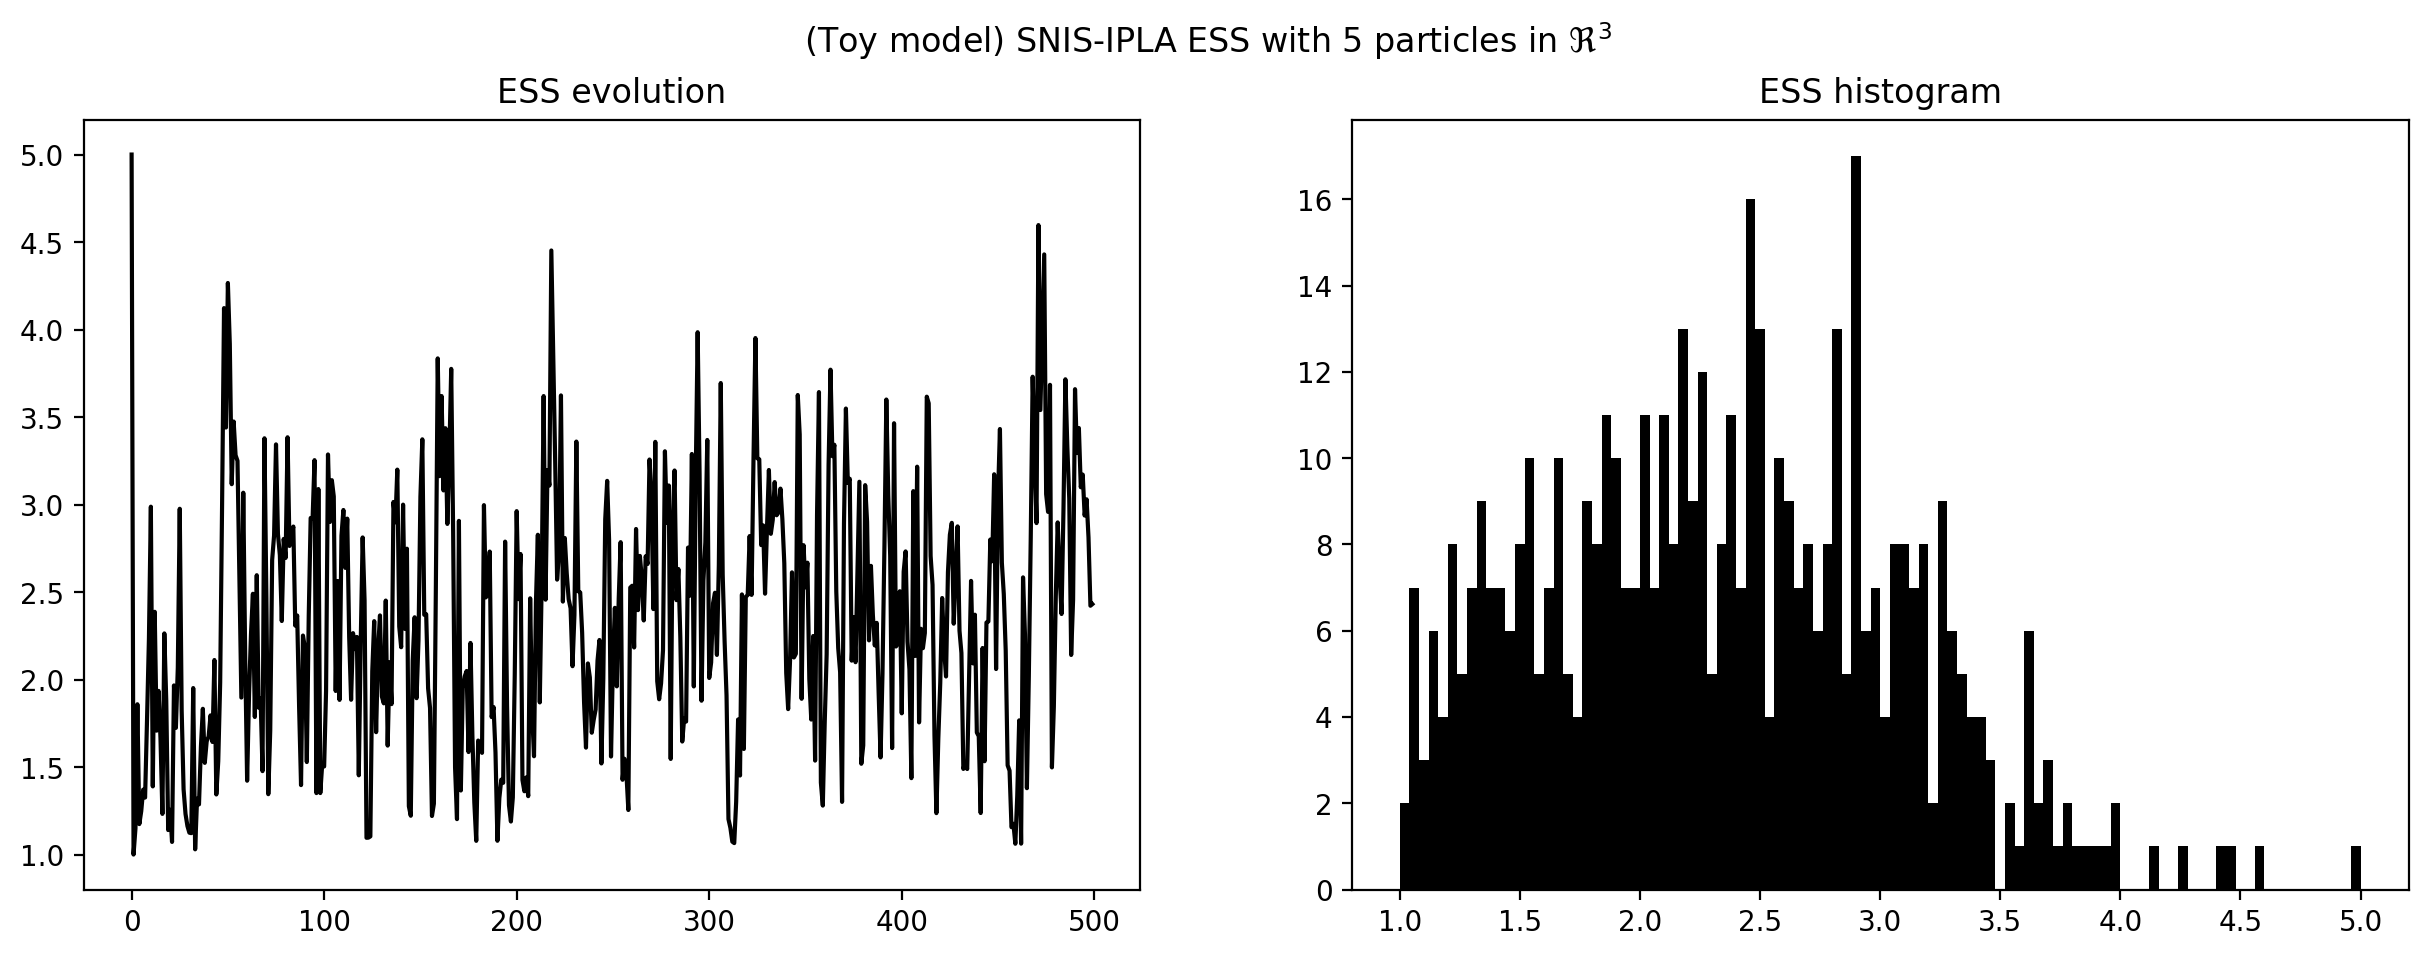

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(SNIS_IPLA_toy.ESS_arr, color="black")
axs[0].set_title(f"ESS evolution")
axs[1].hist(SNIS_IPLA_toy.ESS_arr, bins=100, color="black")
axs[1].set_title(f"ESS histogram")
fig.suptitle(f"(Toy model) SNIS-IPLA ESS with {Nparticles} particles in $\Re^{{{D}}}$")

plt.show()

## Bayesian Logistic Regression

We implement Bayesian logistic regression, where $p$ is of the form:

$$
p_\theta(x, y) = \mathcal{N}(x;\theta 1_{D_x}, 5I_{D_x})\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}
\\= \frac{1}{(2\pi)^{D_x/2}5^{D_x/2}}\exp\left(-\frac{\|x-1_{D_x}\theta\|^2}{10}\right)\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}
$$

And:

$$
\nabla_\theta p_\theta(x,y)= \frac{1}{(2\pi)^{D_x/2}5^{D_x/2}}\exp\left(-\frac{\|x-1_{D_x}\theta\|^2}{10}\right)\prod_{(f,\,l)\in y}s(f^\top x)^l[1-s(f^\top x)]^{1-l}\left(\frac{2}{5}(1_{D_x}\theta - x)\right)
$$

Observe that then, $U$ becomes:

$$
U(\theta, x) = \sum_{(f,\,l)\in y} [\log(1+e^{f^\top x}) - lf^\top x]+ \frac{\|x-1_{D_x}\theta\|^2}{5}
$$

Then:

$$
\nabla_x U(\theta,x) = \sum_{(f,l)\in y}\left[-lf + \frac{fe^{x^\top f}}{1+e^{f^\top x}}\right] + \frac{2}{5}(x-1_{D_x}\theta)
$$

$$
\nabla_\theta U(\theta,x) = \frac{2}{5}(1_{D_x}\theta - x)
$$

And so:

$$
\frac{1}{N}\sum_{i=1}^N\nabla_\theta U(\theta,x_i) = \frac{2}{5N}\sum_{i=1}^N(1_{D_x}\theta - x_i) = \frac{2}{5}(1_{D_x}\theta - \bar{x})
$$

In [15]:
def ave_grad_U_theta_regression(theta, X, y):
    """
    Average gradient of the negative log posterior for logistic regression

    Inputs:
    theta - parameter
    X - data matrix
    y - labels

    Outputs:
    Average gradient of the negative log posterior wrt theta
    """

    return (theta - X).sum(axis = 0).mean()*(2/5)

def grad_U_Xi_regression(theta, Xi, y):
    """
    Gradient of the negative log posterior wrt a single data point Xi for logistic regression

    Inputs:
    theta - parameter
    Xi - data point
    y - labels

    Outputs:
    Gradient of the negative log posterior wrt Xi
    """

    Dx = np.shape(Xi)[0]
    f = y[0]
    l = y[1].reshape(-1,1)
    return  np.sum(-l*f + f*(np.exp(np.dot(f, Xi))/(1 + np.exp(np.dot(f, Xi)))).reshape(-1,1), axis=0) - (2/5)*(np.ones(Dx)*theta - Xi)

def grad_U_theta_regression(theta, Xi, y):
    """
    Gradient of the negative log posterior wrt theta for logistic regression

    Inputs:
    theta - parameter
    Xi - data point
    y - labels

    Outputs:
    Gradient of the negative log posterior wrt theta
    """

    Dx = np.shape(Xi)[0]
    return (2/5)*(np.ones(Dx)*theta - Xi)

def grad_U_X_regression(theta, X, y):
    """
    Gradient of the negative log posterior wrt data matrix X for logistic regression

    Inputs:
    theta - parameter
    X - data matrix
    y - labels

    Outputs:
    Gradient of the negative log posterior wrt X
    """

    out = np.zeros(np.shape(X))
    for i in range(np.shape(X)[1]):
        out[:,i] = grad_U_Xi_regression(theta, X[:,i], y)
    return out

def U_regression(theta, Xi, y):
    """
    Negative log posterior for logistic regression

    Inputs:
    theta - parameter
    Xi - data point
    y - labels

    Outputs:
    Negative log posterior
    """

    f = y[0]
    l = y[1].reshape(-1,1)
    return np.sum(np.log(1+np.exp(np.dot(f, Xi))) - l*np.dot(f, Xi)) + (1/5)*np.dot(theta - Xi, theta - Xi)

In [16]:
D_regression = features.shape[-1]
nsteps_regression = 500
Nparticles_regression = 5
X0 = np.zeros((D_regression, Nparticles_regression))
th0  = np.array([0.0])
nexperiments_regression = 1
grads_U_IPLA_regression = (ave_grad_U_theta_regression, grad_U_X_regression)
grads_U_SNIS_regression = (grad_U_theta_regression, grad_U_X_regression)
gamma_experiments_regression = 1e-2

average_thetas_dict_regression = {"PGD": np.zeros((nsteps_regression+1,1)), "IPLA": np.zeros((nsteps_regression+1,1)),"SNIS-IPLA": np.zeros((nsteps_regression+1,1)), "SVGD-EM": np.zeros((nsteps_regression+1,1))}
for experiment in range(nexperiments_regression):
    PGD_regression = PGD(th0, X0, grads_U_IPLA_regression, gamma=gamma_experiments_regression, y=y_train)
    IPLA_regression = IPLA(th0, X0, grads_U_IPLA_regression, gamma=gamma_experiments_regression, y=y_train)
    SNIS_IPLA_regression = SNIS_IPLA(th0, X0, U_regression, grads_U_SNIS_regression, gamma=gamma_experiments_regression, test=False, y=y_train)
    SVGD_EM_regression = SVGD_EM(th0, X0, grads_U_IPLA_regression, exponential_kernel, grad_exponential_kernel_x2, gamma=gamma_experiments_regression, noise=1, y=y_train)
    for i in tqdm(range(nsteps_regression)):
        PGD_regression.iterate()
        #print(np.shape(PGD_test_regression.X))
        IPLA_regression.iterate()
        SNIS_IPLA_regression.iterate()
        SVGD_EM_regression.iterate()
        # print dimension of X 

    average_thetas_dict_regression["PGD"] = average_thetas_dict_regression["PGD"] + (1/nexperiments_regression) * np.array(PGD_regression.thetas)
    average_thetas_dict_regression["IPLA"] = average_thetas_dict_regression["IPLA"] + (1/nexperiments_regression) * np.array(IPLA_regression.thetas)
    average_thetas_dict_regression["SNIS-IPLA"] = average_thetas_dict_regression["SNIS-IPLA"] + (1/nexperiments_regression) * np.array(SNIS_IPLA_regression.thetas)
    average_thetas_dict_regression["SVGD-EM"] = average_thetas_dict_regression["SVGD-EM"] + (1/nexperiments_regression) * np.array(SVGD_EM_regression.thetas)
    print(f"Experiment {experiment} complete")


100%|██████████| 500/500 [00:03<00:00, 166.27it/s]

Experiment 0 complete


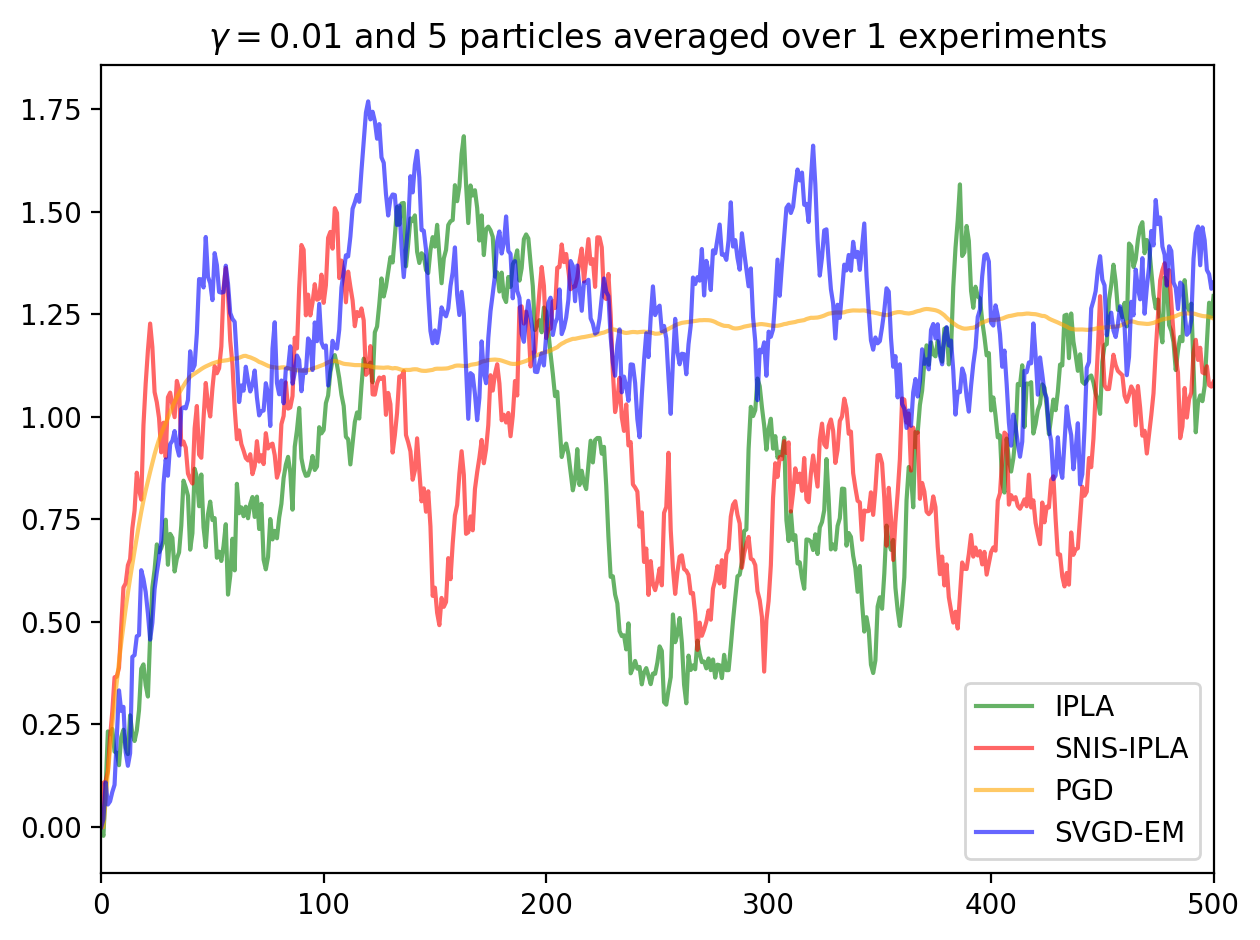

In [17]:
plt.plot(average_thetas_dict_regression["IPLA"], color = "green", label="IPLA", alpha=0.6)
plt.plot(average_thetas_dict_regression["SNIS-IPLA"], color = "red", label="SNIS-IPLA", alpha=0.6)
plt.plot(average_thetas_dict_regression["PGD"], color = "orange", label="PGD", alpha=0.6)
plt.plot(average_thetas_dict_regression["SVGD-EM"], color = "blue", label="SVGD-EM", alpha=0.6)
plt.title(f"(Reg) $\gamma = {gamma_experiments_regression}$ and {Nparticles_regression} particles averaged over {nexperiments_regression} experiments")
plt.xlim([0, nsteps])
plt.legend()
plt.tight_layout()
plt.show()

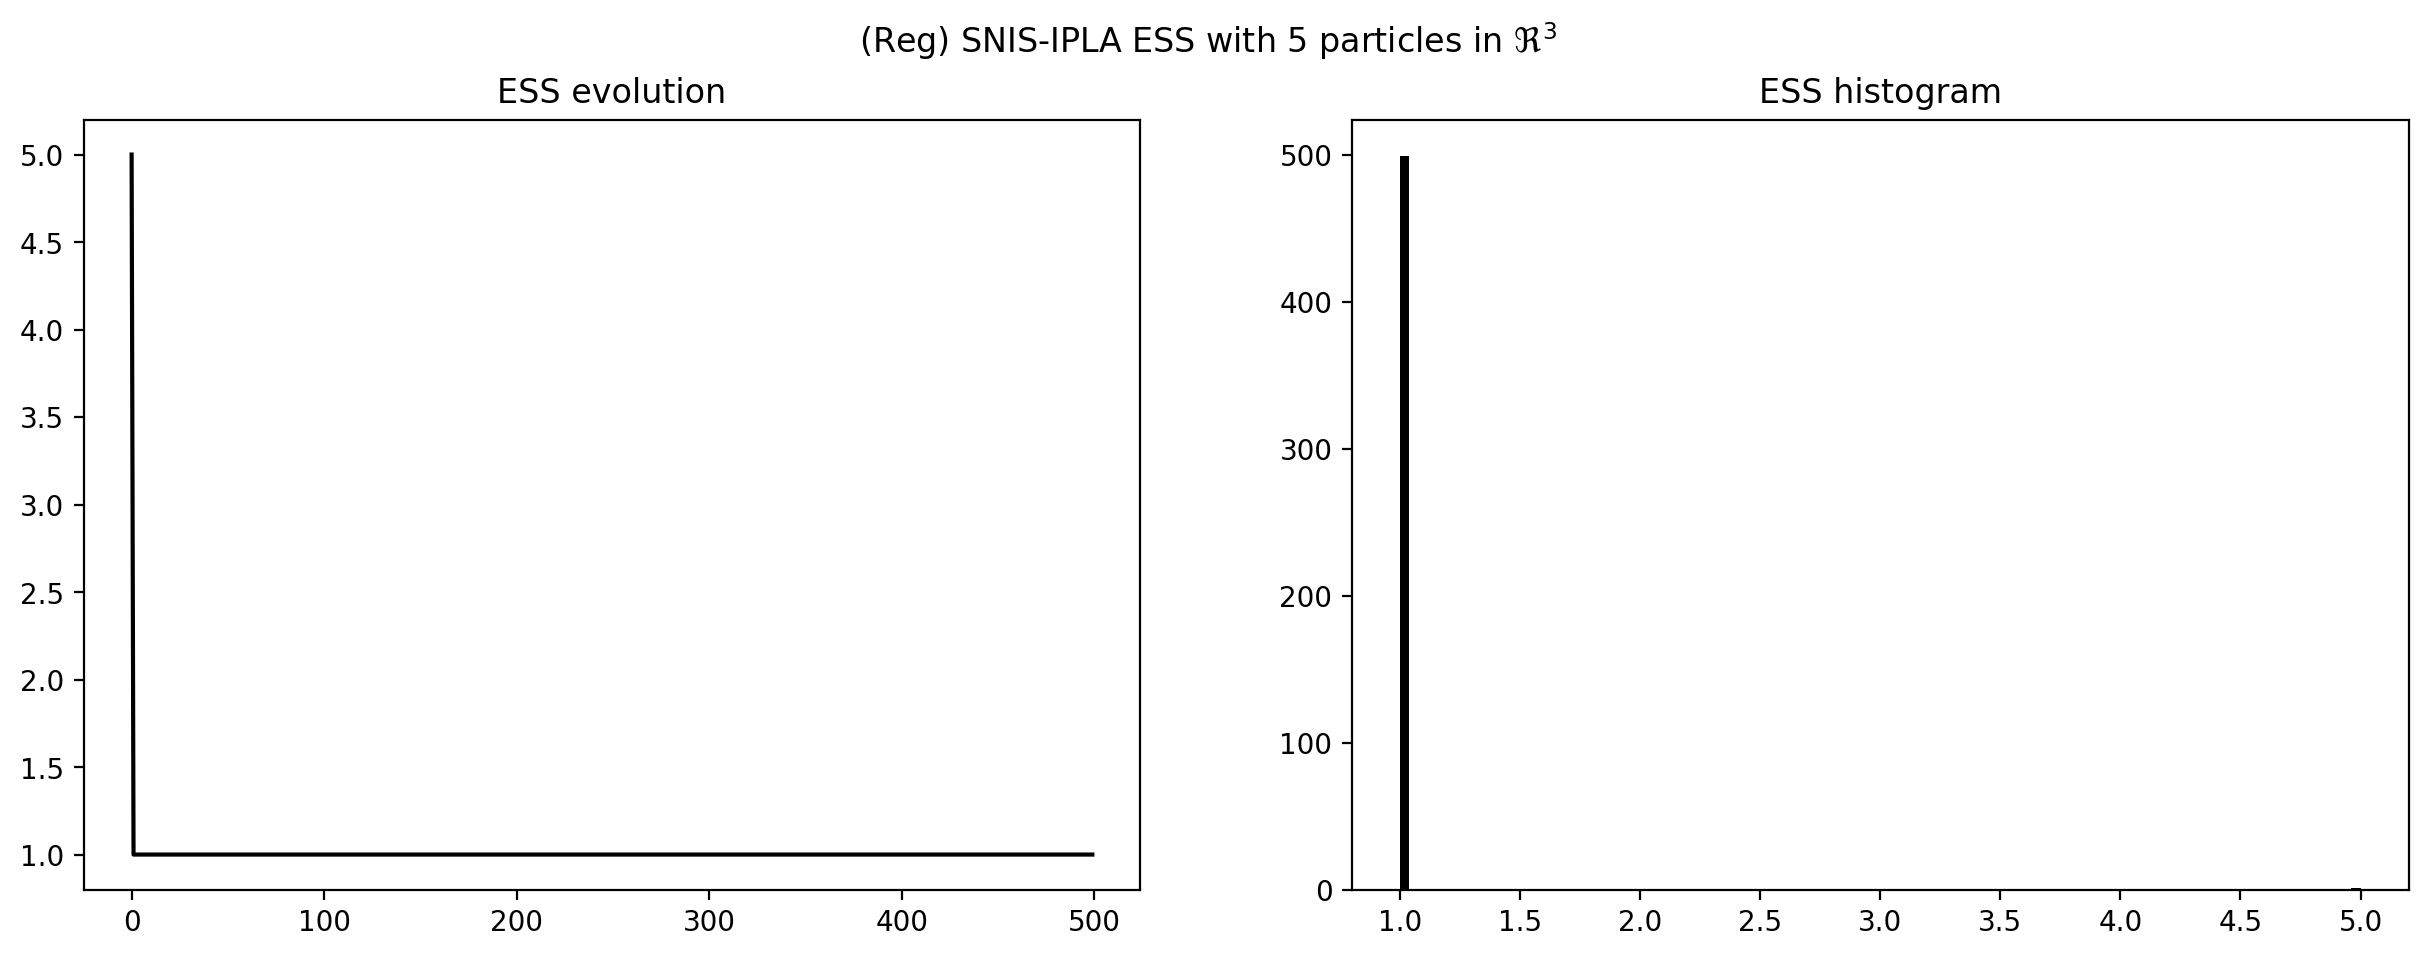

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(SNIS_IPLA_regression.ESS_arr, color="black")
axs[0].set_title(f"ESS evolution")
axs[1].hist(SNIS_IPLA_regression.ESS_arr, bins=100, color="black")
axs[1].set_title(f"ESS histogram")
fig.suptitle(f"(Reg) SNIS-IPLA ESS with {Nparticles} particles in $\Re^{{{D}}}$")

plt.show()

In [24]:
# Extract labels from the trained model
def predict(f, X, thresh=True):
    s = 1/(1+np.exp(-f@X)).mean(axis=1)
    if thresh:
        s[s>0.5] = 1
        s[s<=0.5] = 0
    return s

def accuracy(f, X, labels):
    return (predict(f, X)==labels).mean()

def confusion_matrix(f, X, labels):
    s = predict(f, X)
    tp = np.sum((s==1) & (labels==1))
    tn = np.sum((s==0) & (labels==0))
    fp = np.sum((s==1) & (labels==0))
    fn = np.sum((s==0) & (labels==1))
    return np.array([[tp, fp], [fn, tn]])

PGD_test_accuracy = accuracy(test_features, PGD_regression.X, test_labels)
IPLA_test_accuracy = accuracy(test_features, IPLA_regression.X, test_labels)
SNIS_IPLA_test_accuracy = accuracy(test_features, SNIS_IPLA_regression.X, test_labels)
SVGD_EM_test_accuracy = accuracy(test_features, SVGD_EM_regression.X, test_labels)

PGD_train_accuracy = accuracy(train_features, PGD_regression.X, train_labels)
IPLA_train_accuracy = accuracy(train_features, IPLA_regression.X, train_labels)
SNIS_IPLA_train_accuracy = accuracy(train_features, SNIS_IPLA_regression.X, train_labels)
SVGD_EM_train_accuracy = accuracy(train_features, SVGD_EM_regression.X, train_labels)

print(f"PGD has a test accuracy of {PGD_test_accuracy} and a train accuracy of {PGD_train_accuracy}")
print(f"IPLA has a test accuracy of {IPLA_test_accuracy} and a train accuracy of {IPLA_train_accuracy}")
print(f"SNIS-IPLA has a test accuracy of {SNIS_IPLA_test_accuracy} and a train accuracy of {SNIS_IPLA_train_accuracy}")
print(f"SVGD-EM has a test accuracy of {SVGD_EM_test_accuracy} and a train accuracy of {SVGD_EM_train_accuracy}")

PGD has a test accuracy of 0.9562043795620438 and a train accuracy of 0.9761904761904762
IPLA has a test accuracy of 0.9635036496350365 and a train accuracy of 0.9743589743589743
SNIS-IPLA has a test accuracy of 0.9562043795620438 and a train accuracy of 0.9761904761904762
SVGD-EM has a test accuracy of 0.9635036496350365 and a train accuracy of 0.9798534798534798


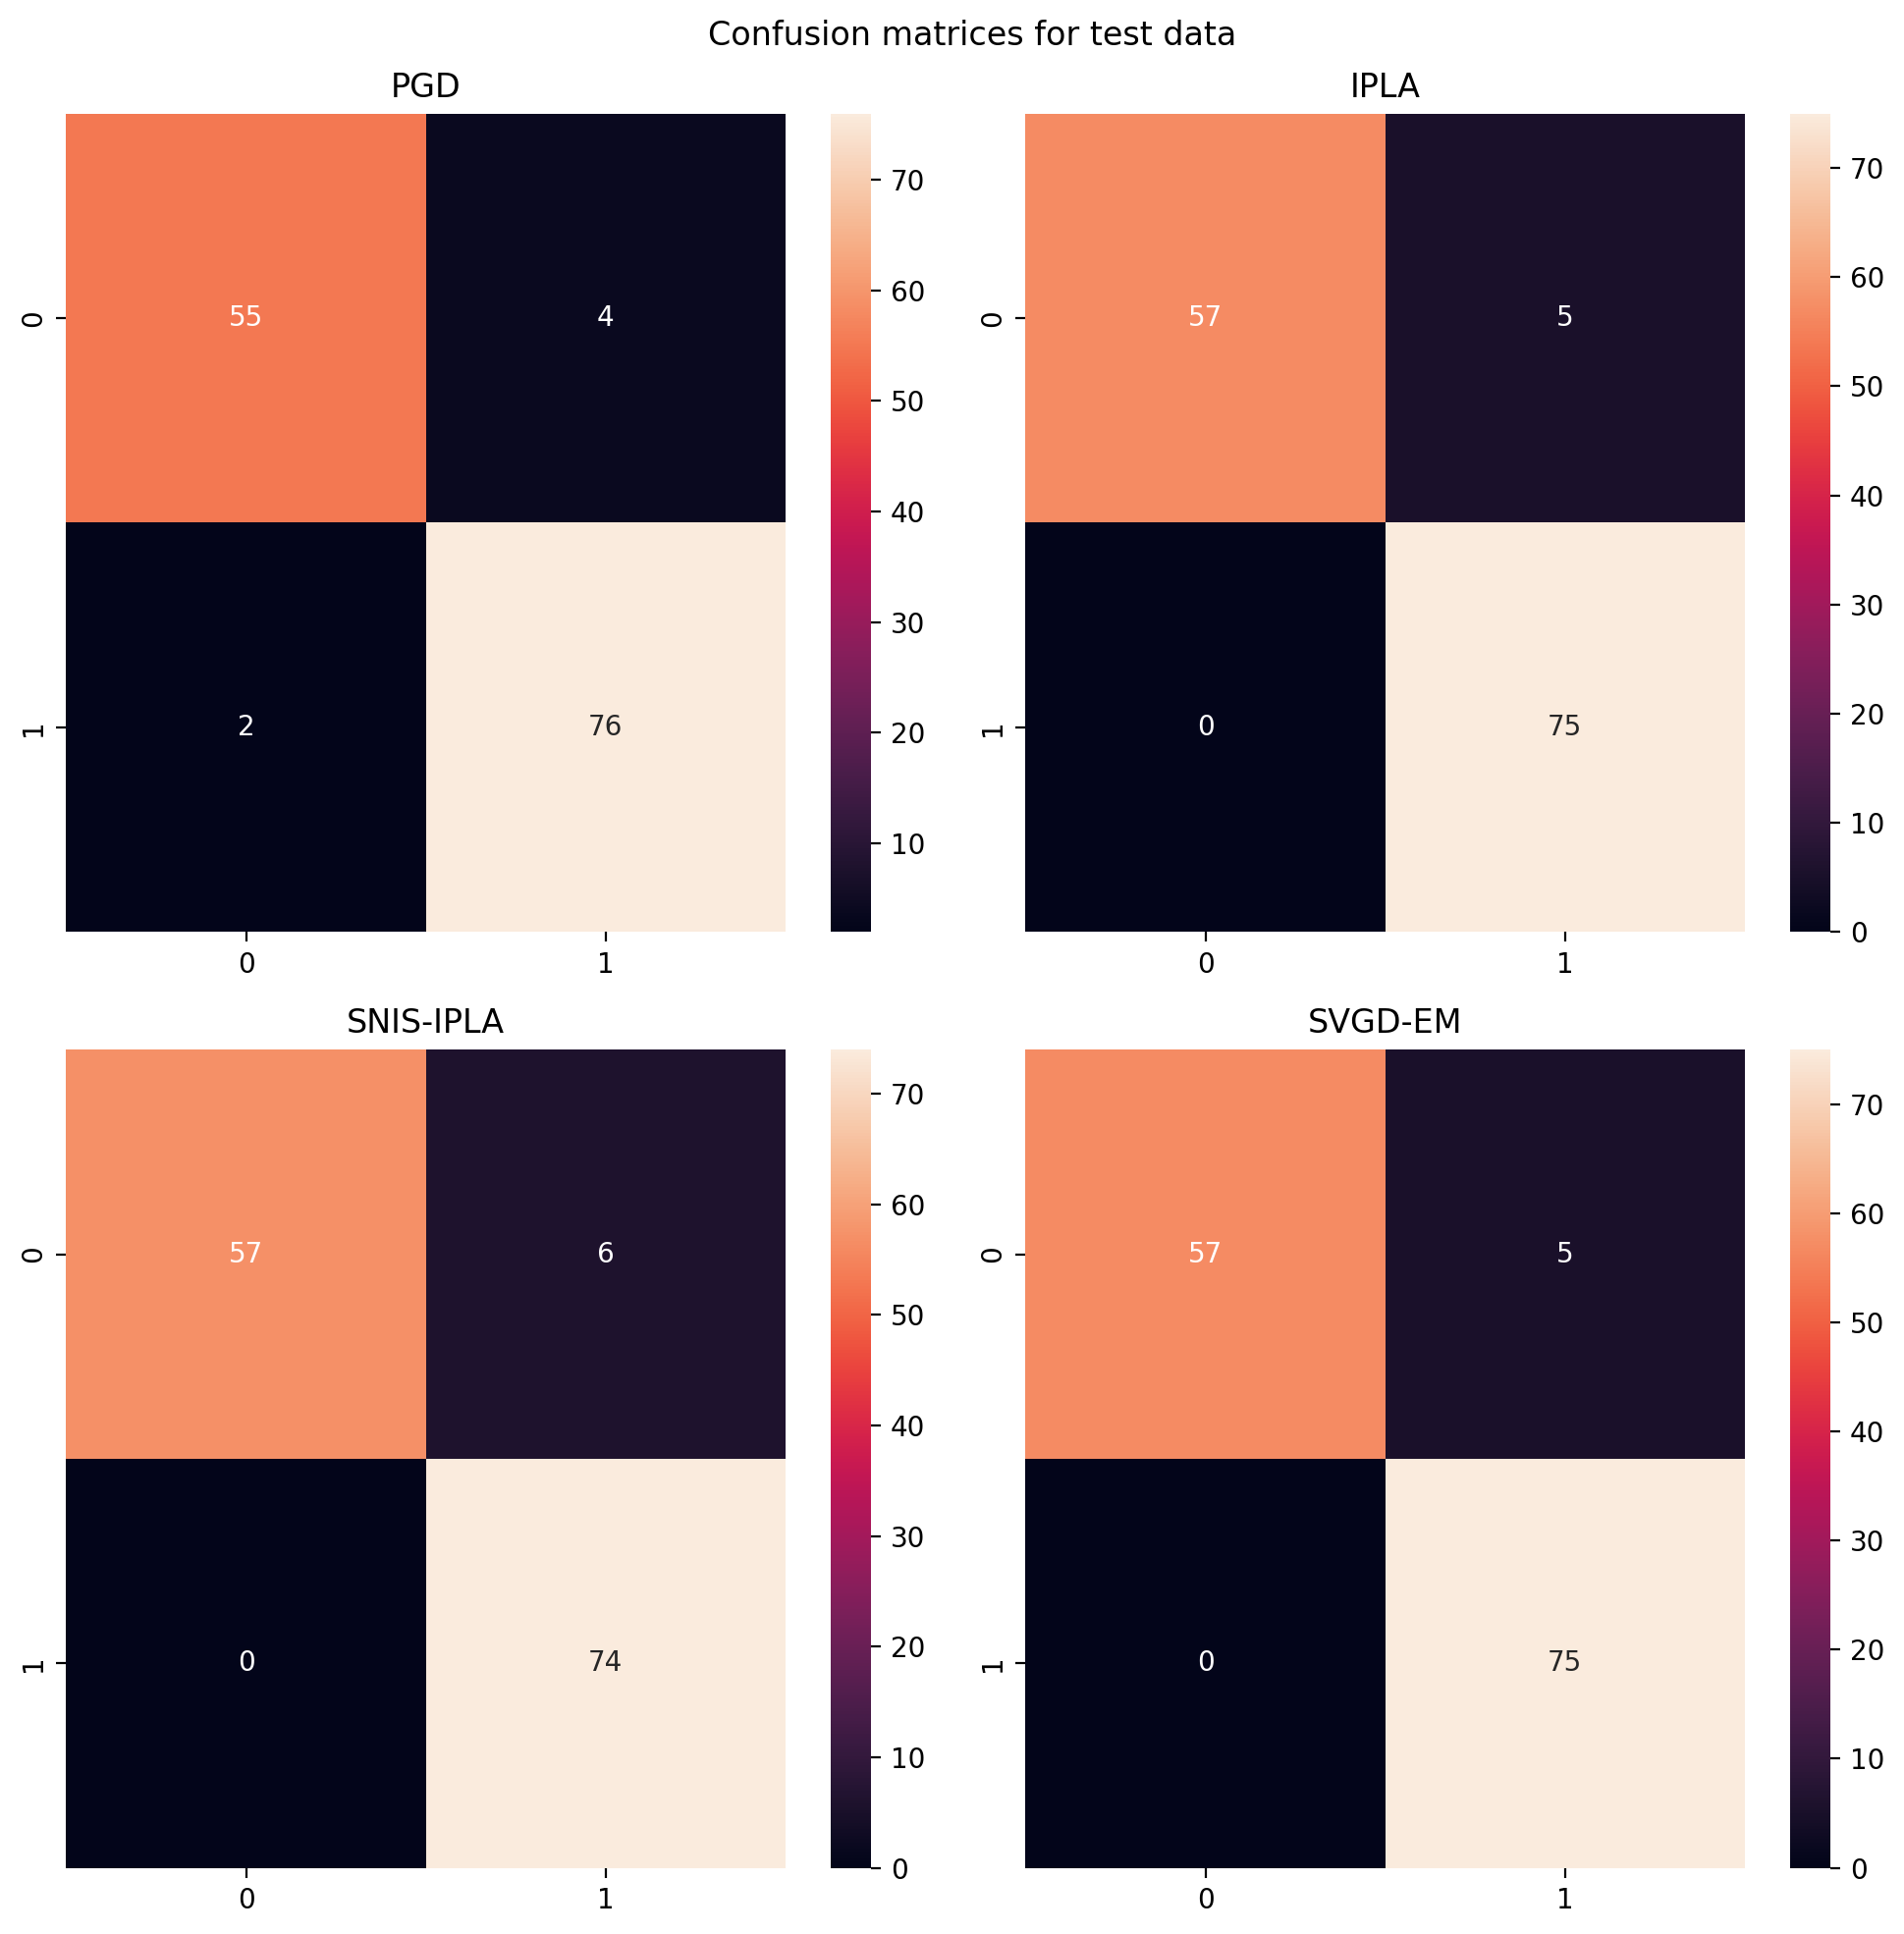

In [25]:
test_PGD_confusion_mat = confusion_matrix(test_features, PGD_regression.X, test_labels)
test_IPLA_confusion_mat = confusion_matrix(test_features, IPLA_regression.X, test_labels)
test_SNIS_IPLA_confusion_mat = confusion_matrix(test_features, SNIS_IPLA_regression.X, test_labels)
test_SVGD_EM_confusion_mat = confusion_matrix(test_features, SVGD_EM_regression.X, test_labels)

# make 2 by 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# in each subplot, plot the confusion matrix using seaborn heatmap
sns.heatmap(test_PGD_confusion_mat, annot=True, fmt='d', ax=axs[0, 0])
sns.heatmap(test_IPLA_confusion_mat, annot=True, fmt='d', ax=axs[0, 1])
sns.heatmap(test_SNIS_IPLA_confusion_mat, annot=True, fmt='d', ax=axs[1, 0])
sns.heatmap(test_SVGD_EM_confusion_mat, annot=True, fmt='d', ax=axs[1, 1])
axs[0,0].set_title('PGD')
axs[0,1].set_title('IPLA')
axs[1,0].set_title('SNIS-IPLA')
axs[1,1].set_title('SVGD-EM')
fig.suptitle('Confusion matrices for test data')
fig.tight_layout()
plt.show()

KDEs

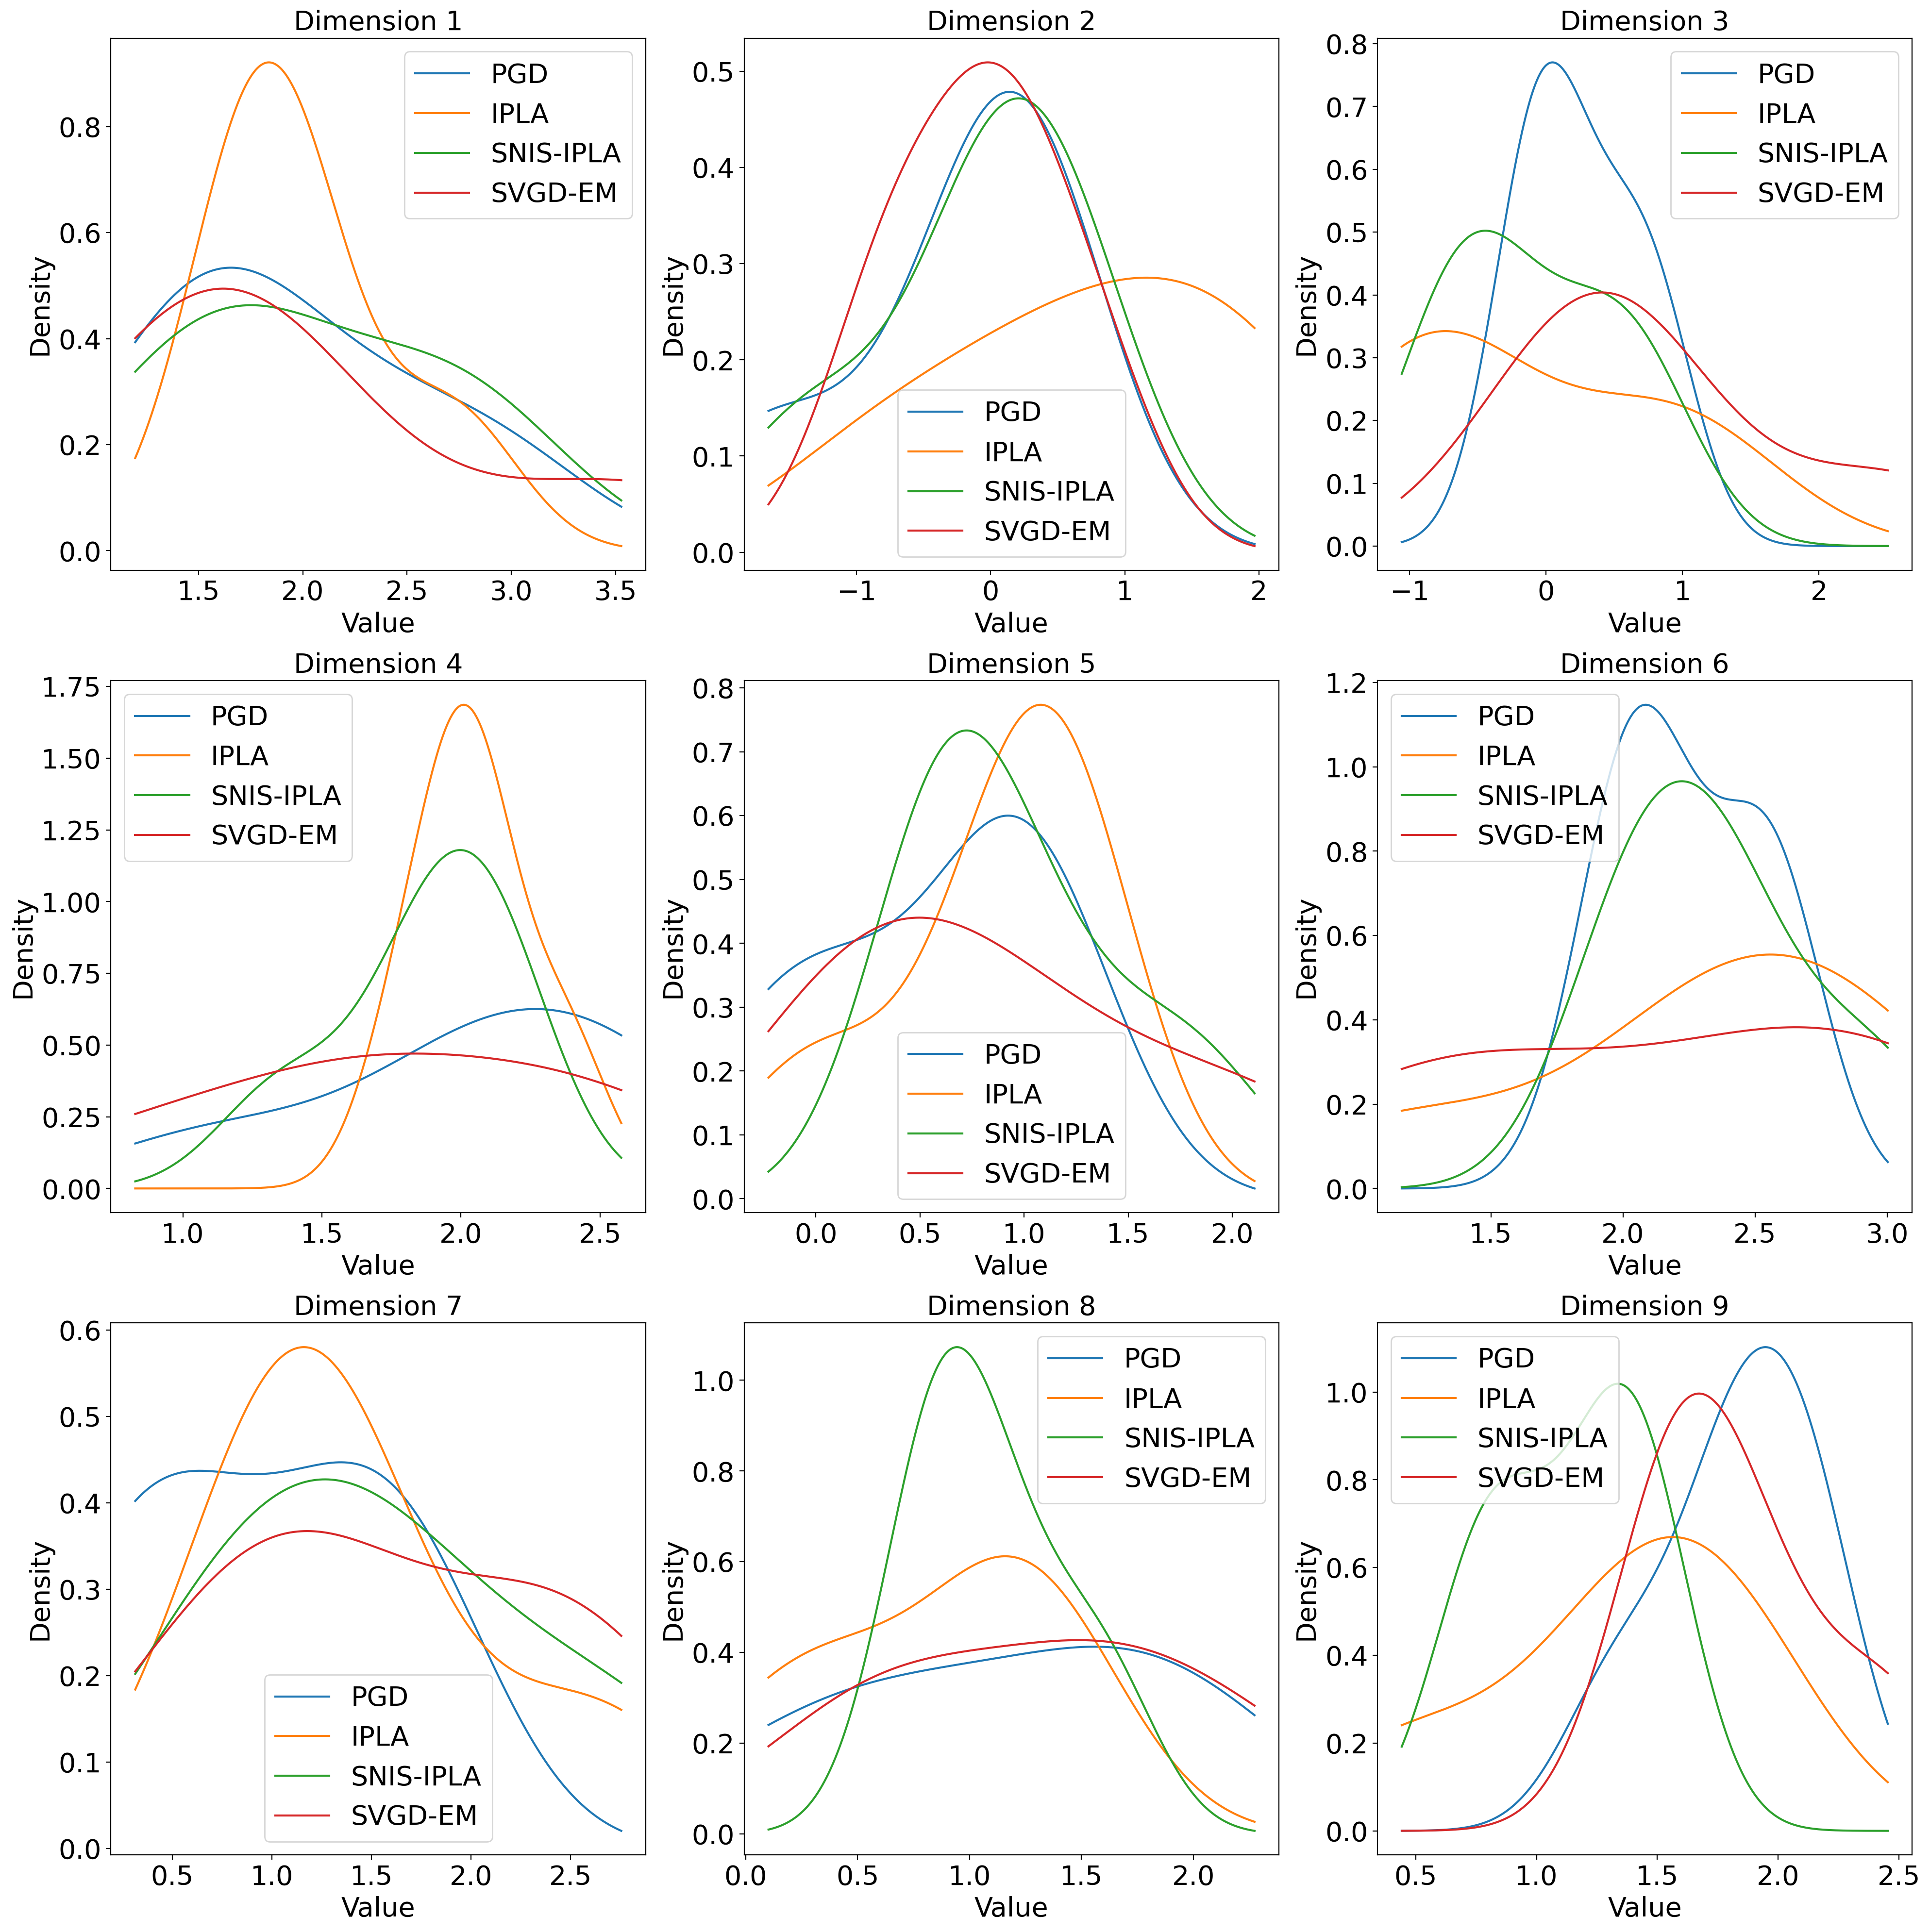

In [26]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

PGD_final_particle_cloud = PGD_regression.Xs[-1]
IPLA_final_particle_cloud = IPLA_regression.Xs[-1]
SNIS_IPLA_final_particle_cloud = SNIS_IPLA_regression.Xs[-1]
SVGD_EM_final_particle_cloud = SVGD_EM_regression.Xs[-1]
D_regression = 9
for i in range(D_regression):
    kde_PGD = stats.gaussian_kde(PGD_final_particle_cloud[i,:])
    kde_IPLA = stats.gaussian_kde(IPLA_final_particle_cloud[i,:])
    kde_SNIS_IPLA = stats.gaussian_kde(SNIS_IPLA_final_particle_cloud[i,:])
    kde_SVGD_EM = stats.gaussian_kde(SVGD_EM_final_particle_cloud[i,:])
    kde_min = min(min(PGD_final_particle_cloud[i,:]), min(IPLA_final_particle_cloud[i,:]), min(SNIS_IPLA_final_particle_cloud[i,:]), min(SVGD_EM_final_particle_cloud[i,:]))
    kde_max = max(max(PGD_final_particle_cloud[i,:]), max(IPLA_final_particle_cloud[i,:]), max(SNIS_IPLA_final_particle_cloud[i,:]), max(SVGD_EM_final_particle_cloud[i,:]))
    x = np.linspace(kde_min, kde_max, 1000)
    axs[i//3, i%3].plot(x, kde_PGD(x), label="PGD")
    axs[i//3, i%3].plot(x, kde_IPLA(x), label="IPLA")
    axs[i//3, i%3].plot(x, kde_SNIS_IPLA(x), label="SNIS-IPLA")
    axs[i//3, i%3].plot(x, kde_SVGD_EM(x), label="SVGD-EM")
    axs[i//3, i%3].set_title("Dimension {}".format(i+1), fontsize=20)
    axs[i//3, i%3].tick_params(axis='both', which='major', labelsize=20)
    axs[i//3, i%3].tick_params(axis='both', which='minor', labelsize=20)
    axs[i//3, i%3].set_xlabel("Value", fontsize=20)
    axs[i//3, i%3].set_ylabel("Density", fontsize=20)
    axs[i//3, i%3].legend(fontsize=20)

fig.tight_layout()
plt.show()